# **IMPORT LIBRARY/MODULE**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import zscore
from tqdm import tqdm


from statsmodels.stats.diagnostic import linear_reset #Ramsey RESET test
from statsmodels.stats.stattools import jarque_bera # Residual Normality test
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF for multicollinearity
from statsmodels.stats.diagnostic import het_breuschpagan #BP test for heteroskedasticity

# **READ FILE AND PREPROCESS DATA**

## **Read file**

In [ ]:
df = pd.read_excel("group3_data.xlsx")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Country Name                           900 non-null    object 
 1   Country Code                           900 non-null    object 
 2   Year                                   900 non-null    int64  
 3   Suicide mortality rate                 900 non-null    float64
 4   Prevalence of bipolar disorder         900 non-null    float64
 5   Prevalence of anxiety disorder         900 non-null    float64
 6   Prevalence of depression               900 non-null    float64
 7   Alcohol use disorders                  900 non-null    float64
 8   Prevalence of eating disorders         900 non-null    float64
 9   Continent                              900 non-null    object 
 10  Current health expenditure per capita  875 non-null    float64
 11  GDP pe

The DataFrame df has 900 rows and 15 columns, with some columns such as `Current health expenditure per capita`, `GDP per capita`, `Inflation`, and `Unemployment` having missing values.

## **Drop null**

In [ ]:
df.columns = [col.strip().split(' (')[0].replace(" ", "_").lower() for col in df.columns]
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 666 entries, 2 to 899
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   country_name                           666 non-null    object 
 1   country_code                           666 non-null    object 
 2   year                                   666 non-null    int64  
 3   suicide_mortality_rate                 666 non-null    float64
 4   prevalence_of_bipolar_disorder         666 non-null    float64
 5   prevalence_of_anxiety_disorder         666 non-null    float64
 6   prevalence_of_depression               666 non-null    float64
 7   alcohol_use_disorders                  666 non-null    float64
 8   prevalence_of_eating_disorders         666 non-null    float64
 9   continent                              666 non-null    object 
 10  current_health_expenditure_per_capita  666 non-null    float64
 11  gdp_per_cap

- After cleaning, the DataFrame has 666 rows and 15 columns, with all columns being complete (no missing values).
- Column names have been renamed to lowercase with underscores.

## **Normalize**

In [ ]:
variables_to_normalize = [
    'prevalence_of_bipolar_disorder',
    'prevalence_of_anxiety_disorder',
    'prevalence_of_eating_disorders',
    'prevalence_of_depression',
    'alcohol_use_disorders'
]

for var in variables_to_normalize:
    df[var] = df[var] * 1000

**Since** the suicide rate is measured per 100,000 people, this step will help normalize the prevalence of mental health disorders into prevalence per 100,000 people.

In [ ]:
df.head()

,country_name,country_code,year,suicide_mortality_rate,prevalence_of_bipolar_disorder,prevalence_of_anxiety_disorder,prevalence_of_depression,alcohol_use_disorders,prevalence_of_eating_disorders,continent,current_health_expenditure_per_capita,gdp_per_capita,inflation,unemployment
2,Afghanistan,AFG,2008,4.6,720.775512,4825.200606,4129.656,659.501,104.483898,Asia,137.703508,381.733238,26.418664,7.878
3,Afghanistan,AFG,2012,4.0,722.916001,4897.918983,4132.485,662.372,113.536770,Asia,155.383026,651.417134,6.441213,7.856
4,Afghanistan,AFG,2016,4.0,725.151614,4990.617027,4135.694,661.850,121.569505,Asia,239.188747,522.082216,4.383892,10.133
5,Albania,ALB,2000,4.9,574.251922,3904.539352,2195.285,1654.338,107.727638,Europe,222.817466,1126.683340,0.050018,19.023
6,Albania,ALB,2004,4.8,575.931987,3922.757146,2222.116,1701.433,116.205704,Europe,316.166335,2373.581292,2.280019,16.306


In [ ]:
df.describe()

,year,suicide_mortality_rate,prevalence_of_bipolar_disorder,prevalence_of_anxiety_disorder,prevalence_of_depression,alcohol_use_disorders,prevalence_of_eating_disorders,current_health_expenditure_per_capita,gdp_per_capita,inflation,unemployment
count,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000
mean,2008.318318,11.013514,697.575885,4377.212424,3521.814610,1587.723796,219.626924,1107.799287,12481.886221,7.092488,7.378351
std,5.602969,8.956871,253.503491,1305.789040,656.897127,895.656970,165.843149,1460.973061,18910.796118,16.056752,5.343756
min,2000.000000,0.500000,192.200622,1954.403153,2194.091000,449.900000,59.860895,19.000000,122.269203,-5.355400,0.150000
25%,2004.000000,5.200000,547.863715,3516.263746,3094.153000,987.957500,99.085360,139.568929,1121.035085,2.002124,3.720000
50%,2008.000000,8.600000,597.839467,4019.297834,3508.550500,1460.450000,156.225493,478.700905,3998.474565,4.064958,5.923500
75%,2012.000000,13.675000,920.025620,5088.015005,3939.231250,1813.768750,291.954483,1470.479015,14924.741200,8.327062,9.929500
max,2016.000000,87.000000,1668.155916,8835.455678,5739.526000,5467.508000,1107.007406,9599.891046,120422.137934,324.996872,29.770000


Statistical summary of all numeric columns: Count, Mean, Standard deviation, Min, Max, 25th, 50th, and 75th percentiles.




In [ ]:
excluded_vars = ['suicide_mortality_rate', 'unemployment', 'inflation', 'year']

df_log = df.copy()
log_vars = [col for col in df_log.select_dtypes(include=[np.number]).columns if col not in excluded_vars]

for col in log_vars:
    df_log[col] = np.log(df_log[col])


df_log.rename(columns={col: f"log_{col}" for col in log_vars}, inplace=True)


df_log.replace([np.inf, -np.inf], np.nan, inplace=True)
df_log.dropna(inplace=True)


y = df_log['suicide_mortality_rate']
X = df_log.drop(columns=['suicide_mortality_rate', 'country_name', 'country_code', 'year', 'continent'], errors='ignore')

X = X.astype(float)
y = y.astype(float)

In [ ]:
df_log.describe()

,year,suicide_mortality_rate,log_prevalence_of_bipolar_disorder,log_prevalence_of_anxiety_disorder,log_prevalence_of_depression,log_alcohol_use_disorders,log_prevalence_of_eating_disorders,log_current_health_expenditure_per_capita,log_gdp_per_capita,inflation,unemployment
count,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000
mean,2008.318318,11.013514,6.476322,8.343564,8.149376,7.243348,5.159224,6.135302,8.325331,7.092488,7.378351
std,5.602969,8.956871,0.390990,0.281131,0.187299,0.493257,0.659076,1.419871,1.589284,16.056752,5.343756
min,2000.000000,0.500000,5.258540,7.577840,7.693523,6.109025,4.092023,2.944439,4.806225,-5.355400,0.150000
25%,2004.000000,5.200000,6.306027,8.165154,8.037269,6.895639,4.595982,4.938389,7.022003,2.002124,3.720000
50%,2008.000000,8.600000,6.393322,8.298862,8.162958,7.286500,5.051300,6.171076,8.293665,4.064958,5.923500
75%,2012.000000,13.675000,6.824401,8.534642,8.278741,7.503162,5.676567,7.293343,9.610769,8.327062,9.929500
max,2016.000000,87.000000,7.419474,9.086528,8.655132,8.606578,7.009416,9.169507,11.698759,324.996872,29.770000


## **Scatter plot**

In [ ]:
num_col = ['log_prevalence_of_bipolar_disorder',
           'log_prevalence_of_anxiety_disorder',
           'log_prevalence_of_depression',
           'log_alcohol_use_disorders',
           'log_prevalence_of_eating_disorders',
           'log_current_health_expenditure_per_capita',
           'log_gdp_per_capita',
           'inflation',
           'unemployment']

In [ ]:
target = 'suicide_mortality_rate'

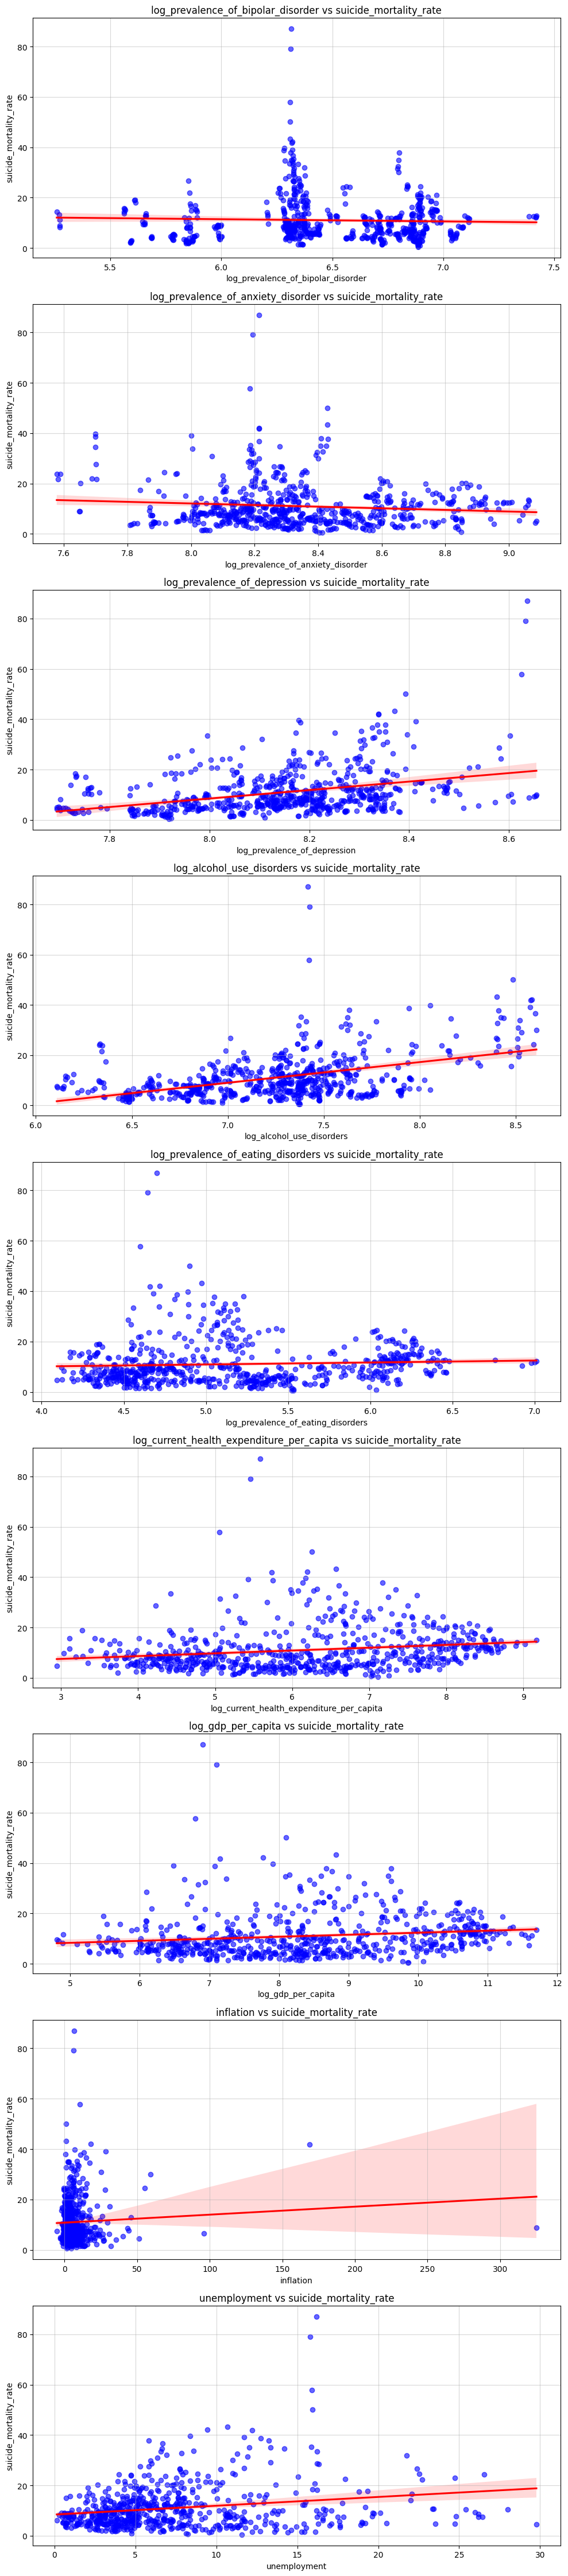

In [ ]:
plt.figure(figsize=(10, 5 * len(num_col)))

num_rows = len(num_col)
for i, num_var in enumerate(num_col, 1):
    plt.subplot(num_rows, 1, i)

    # Scatter plot
    plt.scatter(df_log[num_var], df_log[target], color="blue", alpha=0.6)

    # Regression line (red)
    sns.regplot(x=df_log[num_var],
                y=df_log[target],
                scatter=False,
                color="red")

    # Title and labels
    plt.title(f"{num_var} vs {target}")
    plt.xlabel(num_var)
    plt.ylabel(target)
    plt.grid(alpha=0.5)

# Adjust subplot spacing
plt.subplots_adjust(wspace=0, hspace=5)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

## **Boxplot for detecting and treating outliers**

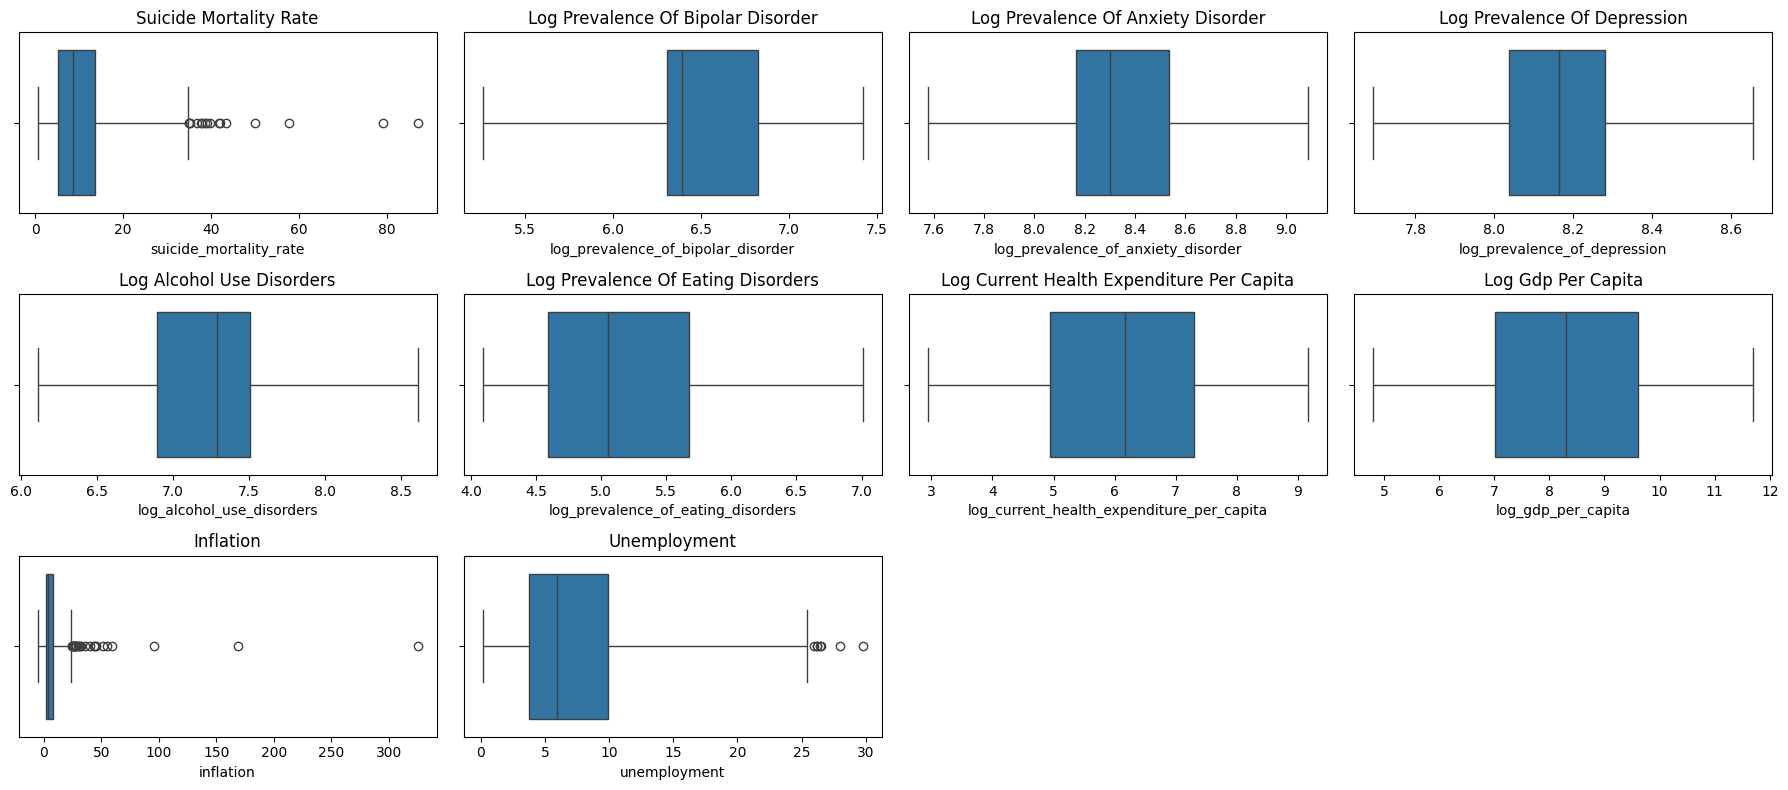

In [ ]:
df_plot = df_log.drop(columns=['year', 'country_name', 'country_code', 'continent'])
columns = df_plot.columns.tolist()

fig, axs = plt.subplots(3, 4, figsize=(18, 8))

for i, col in enumerate(columns):
    row = i // 4
    col_pos = i % 4
    sns.boxplot(x=df_plot[col], ax=axs[row, col_pos], whis=2.5)
    axs[row, col_pos].set_title(col.replace('_', ' ').title())

for j in range(len(columns), 12):
    axs[j // 4, j % 4].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
Q1 = df_log['suicide_mortality_rate'].quantile(0.25)
Q3 = df_log['suicide_mortality_rate'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

df_log = df_log[(df_log['suicide_mortality_rate'] >= lower_bound) & (df_log['suicide_mortality_rate'] <= upper_bound)]

In [ ]:
Q1 = df_log['inflation'].quantile(0.25)
Q3 = df_log['inflation'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

df_log = df_log[(df_log['inflation'] >= lower_bound) & (df_log['inflation'] <= upper_bound)]

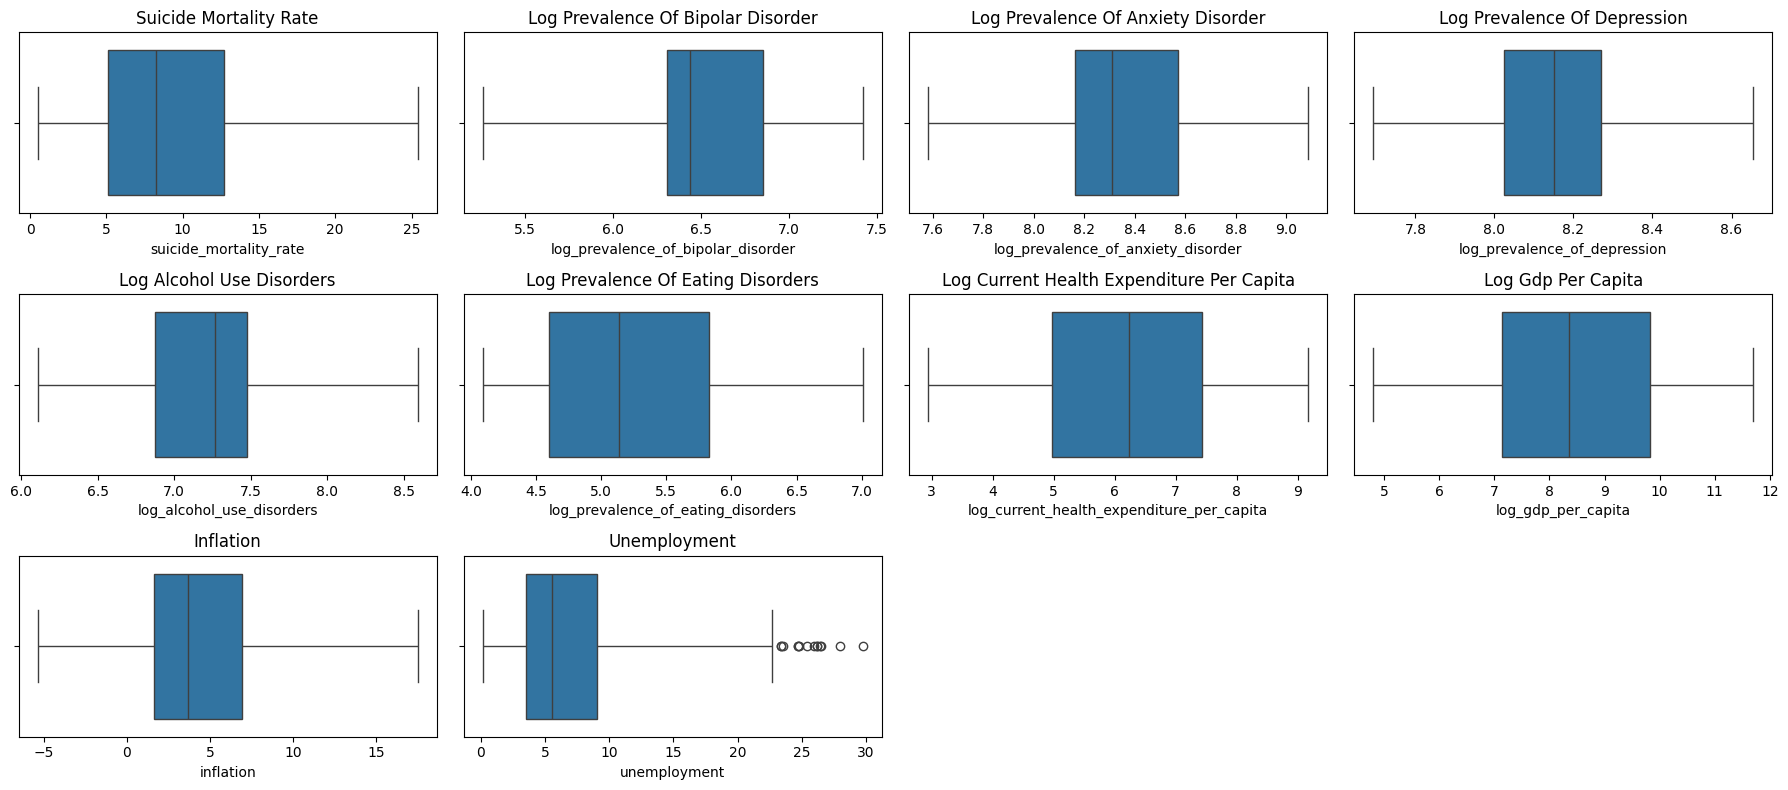

In [ ]:
df_plot = df_log.drop(columns=['year', 'country_name', 'country_code', 'continent'])
columns = df_plot.columns.tolist()

fig, axs = plt.subplots(3, 4, figsize=(18, 8))

for i, col in enumerate(columns):
    row = i // 4
    col_pos = i % 4
    sns.boxplot(x=df_plot[col], ax=axs[row, col_pos], whis=2.5)
    axs[row, col_pos].set_title(col.replace('_', ' ').title())

for j in range(len(columns), 12):
    axs[j // 4, j % 4].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588 entries, 3 to 899
Data columns (total 14 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   country_name                               588 non-null    object 
 1   country_code                               588 non-null    object 
 2   year                                       588 non-null    int64  
 3   suicide_mortality_rate                     588 non-null    float64
 4   log_prevalence_of_bipolar_disorder         588 non-null    float64
 5   log_prevalence_of_anxiety_disorder         588 non-null    float64
 6   log_prevalence_of_depression               588 non-null    float64
 7   log_alcohol_use_disorders                  588 non-null    float64
 8   log_prevalence_of_eating_disorders         588 non-null    float64
 9   continent                                  588 non-null    object 
 10  log_current_health_expenditure_

In [ ]:
df_log.describe()

,year,suicide_mortality_rate,log_prevalence_of_bipolar_disorder,log_prevalence_of_anxiety_disorder,log_prevalence_of_depression,log_alcohol_use_disorders,log_prevalence_of_eating_disorders,log_current_health_expenditure_per_capita,log_gdp_per_capita,inflation,unemployment
count,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000
mean,2008.578231,9.456803,6.488233,8.360441,8.139512,7.192856,5.205924,6.213467,8.438998,4.691502,7.103080
std,5.619903,5.585093,0.406574,0.285906,0.185579,0.457026,0.678614,1.444915,1.598133,4.120504,5.320859
min,2000.000000,0.500000,5.258540,7.582434,7.693523,6.109025,4.092023,2.944439,4.806225,-5.355400,0.150000
25%,2004.000000,5.075000,6.303451,8.164478,8.023982,6.873360,4.597677,4.978605,7.138408,1.665195,3.537250
50%,2008.000000,8.250000,6.439094,8.309910,8.151592,7.269026,5.134231,6.236404,8.349048,3.682269,5.534000
75%,2012.000000,12.700000,6.852073,8.571461,8.270801,7.473190,5.825012,7.438060,9.815937,6.936934,9.074000
max,2016.000000,25.400000,7.419474,9.086528,8.655132,8.590631,7.009416,9.169507,11.698759,17.489449,29.770000


# **MODEL 1**

In [ ]:
y = df_log['suicide_mortality_rate']
X = df_log.drop(columns=['suicide_mortality_rate', 'country_name', 'country_code', 'year', 'continent'], errors='ignore')

X = X.astype(float)
y = y.astype(float)

X = sm.add_constant(X)

model_1 = sm.OLS(y, X).fit()
residuals = model_1.resid

print(model_1.summary())

                              OLS Regression Results                              
Dep. Variable:     suicide_mortality_rate   R-squared:                       0.396
Model:                                OLS   Adj. R-squared:                  0.387
Method:                     Least Squares   F-statistic:                     42.09
Date:                    Sun, 20 Apr 2025   Prob (F-statistic):           7.81e-58
Time:                            15:44:31   Log-Likelihood:                -1697.1
No. Observations:                     588   AIC:                             3414.
Df Residuals:                         578   BIC:                             3458.
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

## **Ramsey's test for linear model**

In [ ]:
reset_test = linear_reset(model_1, power=2, use_f=True)
print("Ramsey RESET Test:", reset_test)

Ramsey RESET Test: <F test: F=0.7281858320893587, p=0.39382596316335305, df_denom=577, df_num=1>


In [ ]:
if reset_test.pvalue > 0.05:
  print("No error, no omitted variable", "The model is satisfied linearity assumption", sep = '\n')
else:
  print("There's an error and one or many omitted variables", "Our model is not linearly validated", sep = '\n')

No error, no omitted variable
The model is satisfied linearity assumption


## **t-test for zero mean**

In [ ]:
from scipy.stats import ttest_1samp
residuals = model_1.resid
t_stat, p_value = ttest_1samp(residuals, 0)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

T-Statistic: 1.706496139849354e-13, P-Value: 0.9999999999998639


## **Correlation matrix and VIF for multicollinear**

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                     feature          VIF
0                                      const  3413.808579
1         log_prevalence_of_bipolar_disorder     4.033381
2         log_prevalence_of_anxiety_disorder     1.936941
3               log_prevalence_of_depression     1.188261
4                  log_alcohol_use_disorders     1.175772
5         log_prevalence_of_eating_disorders    17.818187
6  log_current_health_expenditure_per_capita    15.964839
7                         log_gdp_per_capita    17.521044
8                                  inflation     1.167006
9                               unemployment     1.119337


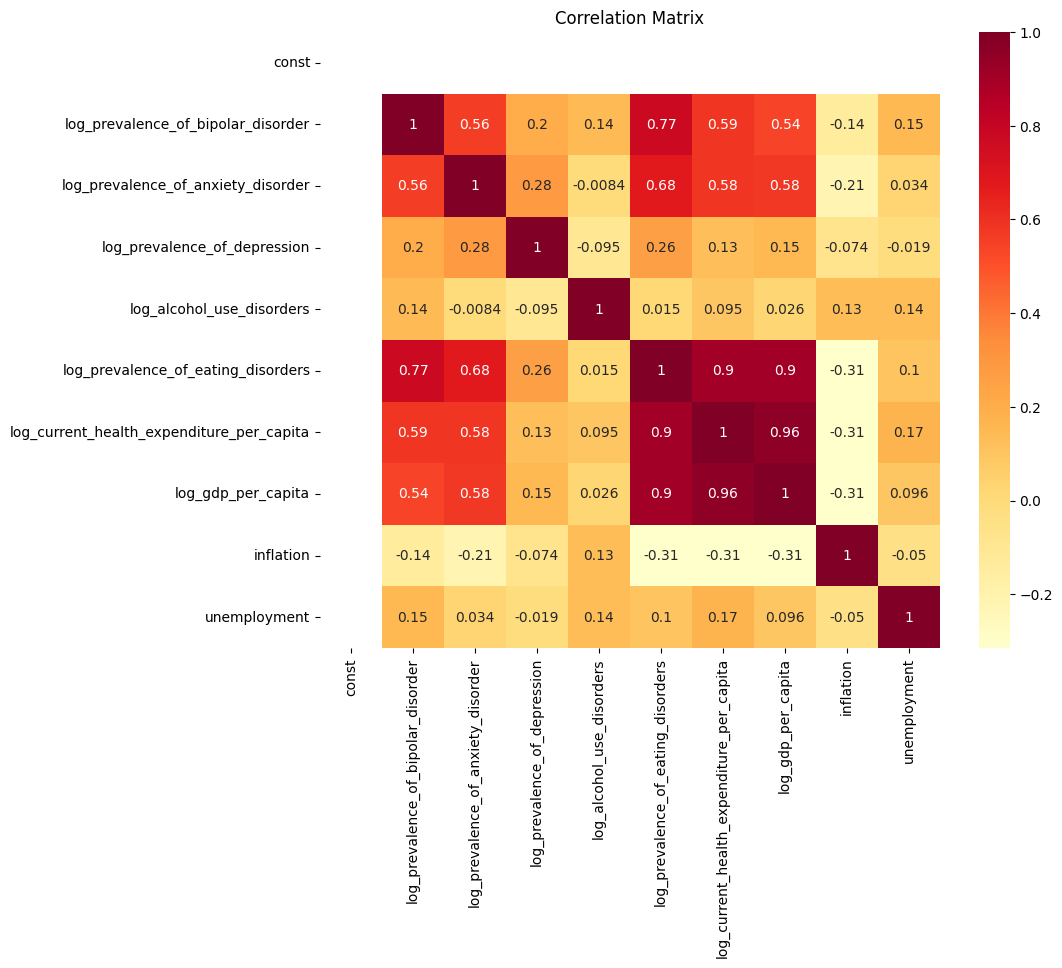

In [ ]:
corr_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

# **MODEL 2: REMOVE `log_gdp_per_capita`**

## **OLS Regression**

In [ ]:
y = df_log['suicide_mortality_rate']
X = df_log.drop(columns=['suicide_mortality_rate', 'country_name', 'country_code', 'year', 'continent', 'log_gdp_per_capita'], errors='ignore')

X = X.astype(float)
y = y.astype(float)

X = sm.add_constant(X)

model_2 = sm.OLS(y, X).fit()
residuals = model_2.resid


print(model_2.summary())

                              OLS Regression Results                              
Dep. Variable:     suicide_mortality_rate   R-squared:                       0.392
Model:                                OLS   Adj. R-squared:                  0.383
Method:                     Least Squares   F-statistic:                     46.64
Date:                    Sun, 20 Apr 2025   Prob (F-statistic):           7.44e-58
Time:                            15:44:33   Log-Likelihood:                -1699.0
No. Observations:                     588   AIC:                             3416.
Df Residuals:                         579   BIC:                             3455.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

## **Ramsey's test for linear model**

In [ ]:
reset_test = linear_reset(model_2, power=2, use_f=True)
print("Ramsey RESET Test:", reset_test)

Ramsey RESET Test: <F test: F=1.113683691403977, p=0.2917235008962452, df_denom=578, df_num=1>


In [ ]:
if reset_test.pvalue > 0.05:
  print("No error, no omitted variable", "The model is satisfied linearity assumption", sep = '\n')
else:
  print("There's an error and one or many omitted variables", "Our model is not linearly validated", sep = '\n')

No error, no omitted variable
The model is satisfied linearity assumption


## **t-test for zero mean**

In [ ]:
from scipy.stats import ttest_1samp
residuals = model_2.resid
t_stat, p_value = ttest_1samp(residuals, 0)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

T-Statistic: 2.0519584532507295e-13, P-Value: 0.9999999999998364


## **Correlation matrix and VIF for multicollinear**

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                     feature          VIF
0                                      const  3231.134275
1         log_prevalence_of_bipolar_disorder     3.411409
2         log_prevalence_of_anxiety_disorder     1.931323
3               log_prevalence_of_depression     1.185238
4                  log_alcohol_use_disorders     1.171068
5         log_prevalence_of_eating_disorders    14.089693
6  log_current_health_expenditure_per_capita     7.930084
7                                  inflation     1.163050
8                               unemployment     1.095427


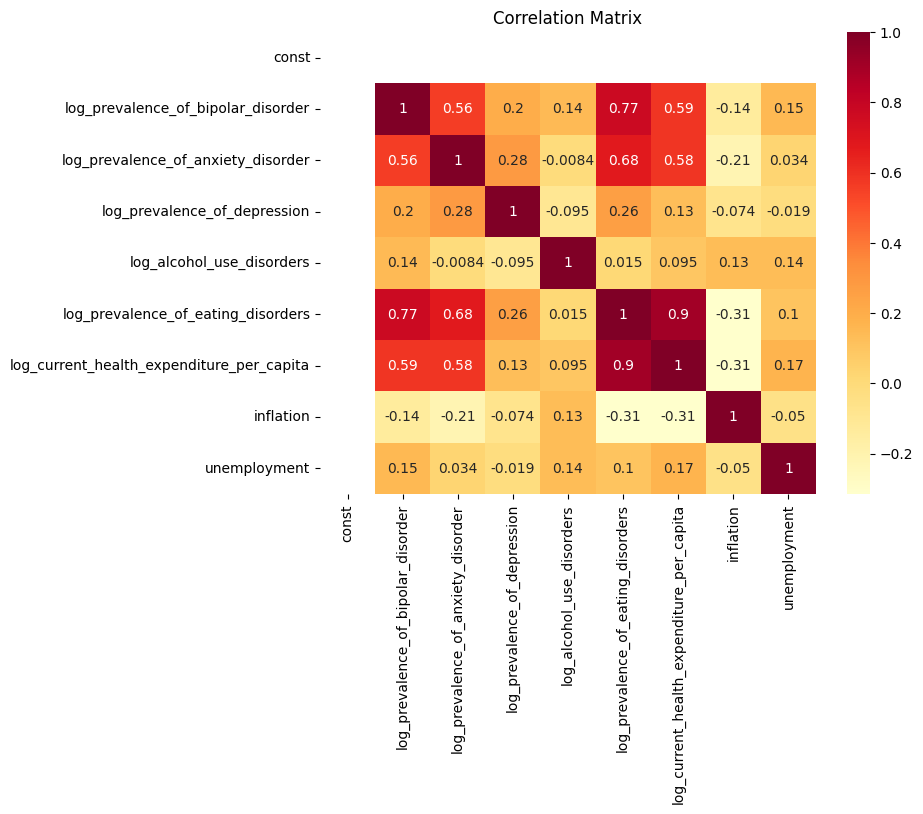

In [ ]:
corr_matrix = X.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

# **MODEL 3: REMOVE `log_prevalence_of_eating_disorders`**

## **OLS Regression**

In [ ]:
y = df_log['suicide_mortality_rate']
X = df_log.drop(columns=['suicide_mortality_rate', 'country_name', 'country_code', 'year', 'continent', 'log_gdp_per_capita', 'log_prevalence_of_eating_disorders'], errors='ignore')

X = X.astype(float)
y = y.astype(float)

X = sm.add_constant(X)

model_3 = sm.OLS(y, X).fit()
residuals = model_3.resid

print(model_3.summary())

                              OLS Regression Results                              
Dep. Variable:     suicide_mortality_rate   R-squared:                       0.385
Model:                                OLS   Adj. R-squared:                  0.378
Method:                     Least Squares   F-statistic:                     51.90
Date:                    Sun, 20 Apr 2025   Prob (F-statistic):           2.28e-57
Time:                            15:44:35   Log-Likelihood:                -1702.3
No. Observations:                     588   AIC:                             3421.
Df Residuals:                         580   BIC:                             3456.
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

**Ramsey's test for linear model**

In [ ]:
reset_test = linear_reset(model_3, power=2, use_f=True)
print("Ramsey RESET Test:", reset_test)

Ramsey RESET Test: <F test: F=0.015245417955895837, p=0.9017759272935483, df_denom=579, df_num=1>


In [ ]:
if reset_test.pvalue > 0.05:
  print("No error, no omitted variable", "The model is satisfied linearity assumption", sep = '\n')
else:
  print("There's an error and one or many omitted variables", "Our model is not linearly validated", sep = '\n')

No error, no omitted variable
The model is satisfied linearity assumption


## **t-test for zero mean**

In [ ]:
from scipy.stats import ttest_1samp
residuals = model_3.resid
t_stat, p_value = ttest_1samp(residuals, 0)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

T-Statistic: 2.5585628505742805e-13, P-Value: 0.9999999999997959


## **Correlation matrix and VIF for multicollinear**

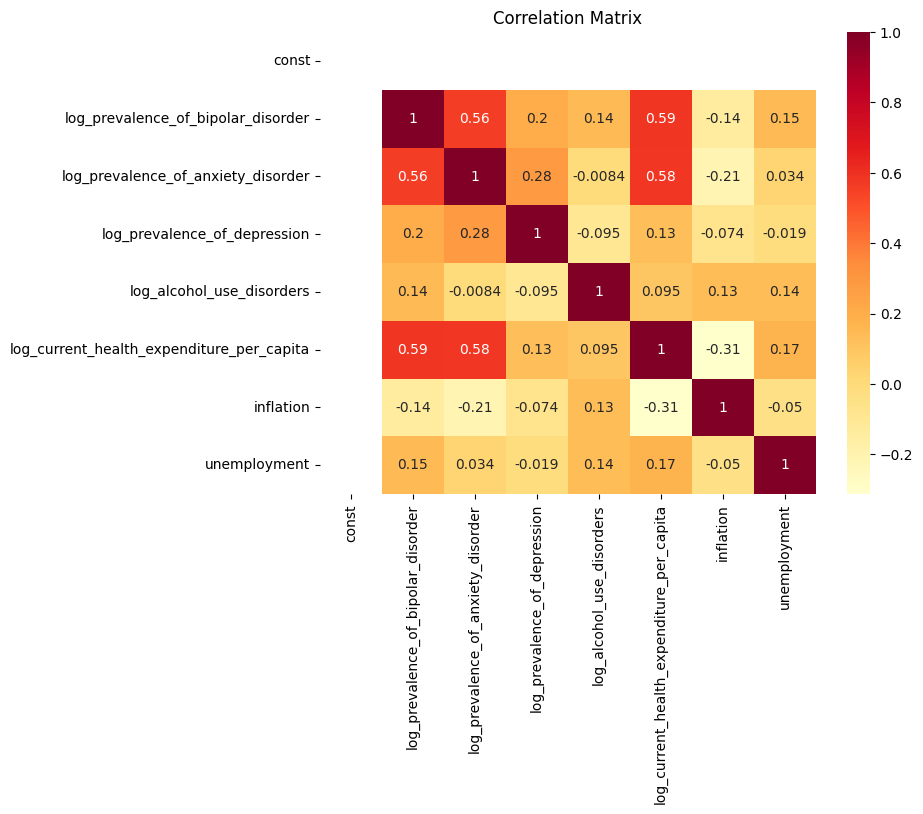

In [ ]:
corr_matrix = X.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                     feature          VIF
0                                      const  2896.598764
1         log_prevalence_of_bipolar_disorder     1.783510
2         log_prevalence_of_anxiety_disorder     1.834156
3               log_prevalence_of_depression     1.110304
4                  log_alcohol_use_disorders     1.088232
5  log_current_health_expenditure_per_capita     1.953321
6                                  inflation     1.147681
7                               unemployment     1.059134


## **5. BP-test for Heteroskedasticity**

In [ ]:
y_pred = model_3.predict(X)

In [ ]:
bp_test = het_breuschpagan(residuals, X)

bp_results = {
    "Lagrange multiplier statistic": bp_test[0],
    "p-value": bp_test[1],
    "F-statistic": bp_test[2],
    "F p-value": bp_test[3]
}

print("Breusch-Pagan Test Results:")
for key, value in bp_results.items():
    print(f"{key}: {value:.4e}")

Breusch-Pagan Test Results:
Lagrange multiplier statistic: 3.4713e+01
p-value: 1.2663e-05
F-statistic: 5.1984e+00
F p-value: 9.2271e-06


In [ ]:
pval = bp_test[1]
if pval < 0.05:
    print("Homoskedasticity is violated.")
else:
    print("Homoskedasticity assumption is not violated.")
print(pval)

Homoskedasticity is violated.
1.2662710917134855e-05


## **6. Durbin-Watson test for autocorrelation**

In [ ]:
from statsmodels.stats.stattools import durbin_watson

independent_vars = df_log.drop(columns=['suicide_mortality_rate', 'country_name', 'country_code', 'year',
                                        'continent', 'log_gdp_per_capita', 'log_prevalence_of_eating_disorders'], errors='ignore')
y = df_log['suicide_mortality_rate']

print("\nDurbin-Watson test for autocorrelation:")
for var in independent_vars:
    X_dw = sm.add_constant(df_log[[var]])
    model = sm.OLS(y, X_dw).fit()
    dw_stat = durbin_watson(model.resid)
    print(f"\nIndependent variable: {var}")
    print(f"Durbin-Watson statistic: {dw_stat:.4f}")



Durbin-Watson test for autocorrelation:

Independent variable: log_prevalence_of_bipolar_disorder
Durbin-Watson statistic: 0.5775

Independent variable: log_prevalence_of_anxiety_disorder
Durbin-Watson statistic: 0.5721

Independent variable: log_prevalence_of_depression
Durbin-Watson statistic: 0.5916

Independent variable: log_alcohol_use_disorders
Durbin-Watson statistic: 0.5488

Independent variable: log_current_health_expenditure_per_capita
Durbin-Watson statistic: 0.6355

Independent variable: inflation
Durbin-Watson statistic: 0.5998

Independent variable: unemployment
Durbin-Watson statistic: 0.5733


## **7. Normality of residual**

n = 588

# **GLS regression**

## **Construct Model**

In [ ]:
X = df_log[['log_prevalence_of_bipolar_disorder',
            'log_prevalence_of_anxiety_disorder',
            'log_prevalence_of_depression',
            'log_alcohol_use_disorders',
            'log_current_health_expenditure_per_capita',
            'inflation',
            'unemployment']].astype(float)

y = df_log['suicide_mortality_rate'].astype(float)

X = sm.add_constant(X)

# Fit the OLS model to get residuals
ols_model = sm.OLS(y, X).fit()
residuals = ols_model.resid
y_cap = ols_model.predict(X)

# Binning forecast values
bins = list(range(int(y_cap.min()), int(y_cap.max()) + 1))
ycap_binned = pd.cut(y_cap, bins=bins)

# Calculate variance of residuals within each bin
bin_variances = []
bin_midpoints = []

for interval in ycap_binned.cat.categories:
    idx = ycap_binned == interval
    if idx.sum() > 1:
        var = residuals[idx].var()
        midpoint = (interval.left + interval.right) / 2
        bin_variances.append(var)
        bin_midpoints.append(midpoint)

# Regress log-variance ~ midpoint
log_variances = np.log(bin_variances)
df_var = pd.DataFrame({
    'midpoint': bin_midpoints,
    'log_variance': log_variances
})
var_model = sm.OLS(df_var['log_variance'], sm.add_constant(df_var['midpoint'])).fit()

# Predict the variance for the entire data set
fitted_log_var = var_model.predict(sm.add_constant(y_cap))
fitted_var = np.exp(fitted_log_var)

# Create Sigma matrix for GLS
sigma_matrix = np.diag(fitted_var)

# Fit the GLS model
gls_model = sm.GLS(y, X, sigma=sigma_matrix)
gls_pre_results = gls_model.fit()

# GLS + HAC (robust với heteroskedasticity + autocorrelation)
gls_results = gls_pre_results.get_robustcov_results(cov_type='HAC', maxlags = 1)
print("\nGLS + HAC:")
print(gls_results.summary())



GLS + HAC:
                              GLS Regression Results                              
Dep. Variable:     suicide_mortality_rate   R-squared:                       0.344
Model:                                GLS   Adj. R-squared:                  0.336
Method:                     Least Squares   F-statistic:                     29.46
Date:                    Sun, 20 Apr 2025   Prob (F-statistic):           7.63e-35
Time:                            15:44:37   Log-Likelihood:                -1687.6
No. Observations:                     588   AIC:                             3391.
Df Residuals:                         580   BIC:                             3426.
Df Model:                               7                                         
Covariance Type:                      HAC                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [ ]:
# Comparison of coefficient estimates between OLS and GLS
coefficients_comparison = pd.DataFrame({
    'OLS': model_3.params,
    'GLS': gls_results.params
})
print("=== Coefficients Comparison ===")
print(coefficients_comparison)

# Comparison of standard errors between OLS and GLS
std_errors_comparison = pd.DataFrame({
    'OLS': model_3.bse,
    'GLS': gls_results.bse
})
print("\n=== Standard Errors Comparison ===")
print(std_errors_comparison)

=== Coefficients Comparison ===
                                                 OLS        GLS
const                                     -55.175643 -65.846213
log_prevalence_of_bipolar_disorder         -3.521470  -3.744095
log_prevalence_of_anxiety_disorder         -5.434959  -4.518159
log_prevalence_of_depression               10.754737  11.397565
log_alcohol_use_disorders                   4.593810   4.767157
log_current_health_expenditure_per_capita   2.015511   1.737558
inflation                                  -0.055114  -0.085853
unemployment                                0.010355  -0.018246

=== Standard Errors Comparison ===
                                                OLS        GLS
const                                      9.778762  13.984621
log_prevalence_of_bipolar_disorder         0.597321   0.796156
log_prevalence_of_anxiety_disorder         0.861398   1.265976
log_prevalence_of_depression               1.032529   1.112830
log_alcohol_use_disorders                

## **Detect and corect residual and influence points**

In [ ]:
residuals_gls = gls_results.resid
standardized_gls_resid = zscore(residuals_gls)



In [ ]:
from scipy.stats import zscore
residuals_gls = gls_results.resid
standardized_gls_resid = zscore(residuals_gls)
df_log["gls_outlier_z>3"] = np.abs(standardized_gls_resid) > 3


In [ ]:
residuals_gls = gls_results.resid
standardized_gls_resid = zscore(residuals_gls)
standardized_gls_resid_np = np.asarray(standardized_gls_resid)

# Flag |z| > 3
outlier_mask_z3 = np.abs(standardized_gls_resid_np) > 3
outlier_indices_z3 = np.where(outlier_mask_z3)[0]

df_log["gls_outlier_z>3"] = False
df_log.loc[df_log.index[outlier_indices_z3], "gls_outlier_z>3"] = True

gls_outliers_z3 = df_log[df_log["gls_outlier_z>3"] == True]
print(gls_outliers_z3)

    country_name country_code  year  suicide_mortality_rate  \
410        Japan          JPN  2000                    23.9   
411        Japan          JPN  2004                    24.1   
412        Japan          JPN  2008                    24.4   
767     Suriname          SUR  2008                    24.5   
768     Suriname          SUR  2012                    25.2   

     log_prevalence_of_bipolar_disorder  log_prevalence_of_anxiety_disorder  \
410                            6.548598                            7.951466   
411                            6.578126                            7.955562   
412                            6.563019                            7.916878   
767                            6.836148                            8.351886   
768                            6.837994                            8.358631   

     log_prevalence_of_depression  log_alcohol_use_disorders  \
410                      8.002684                   6.344804   
411               

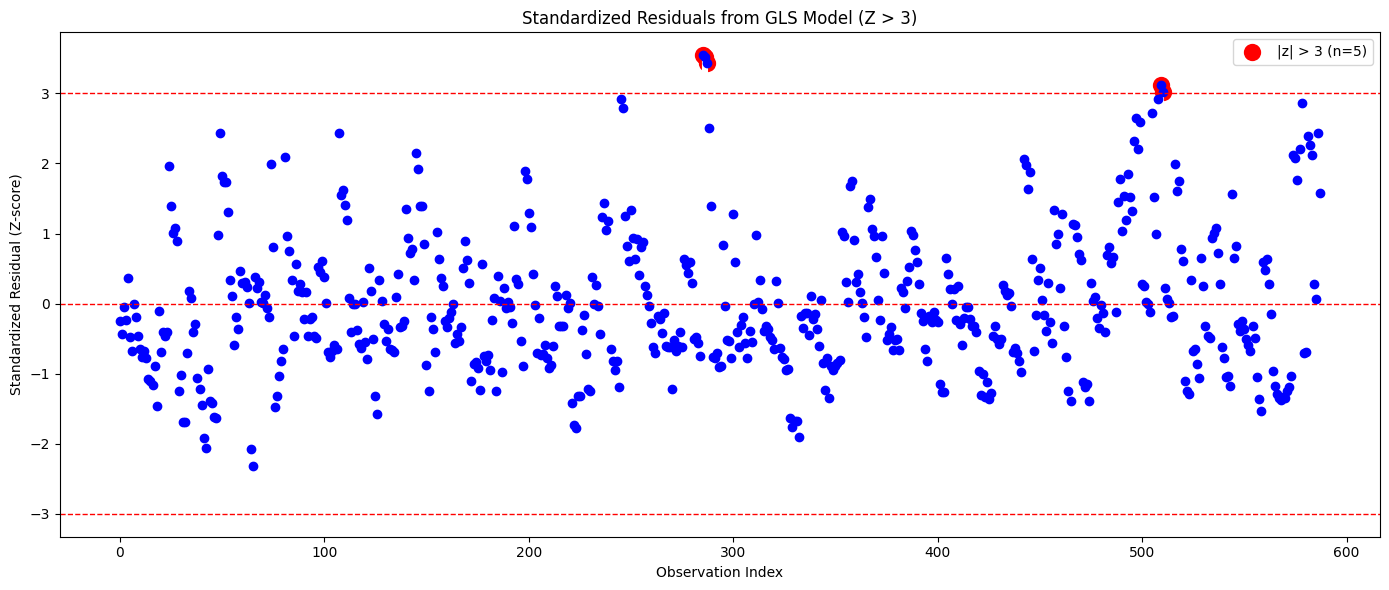

In [ ]:
plt.figure(figsize=(14, 6))
plt.stem(standardized_gls_resid_np, linefmt='white', markerfmt='bo', basefmt=' ')
plt.scatter(outlier_indices_z3, standardized_gls_resid_np[outlier_indices_z3],
            color='red', edgecolors='red', s=120, linewidth=1.5,
            label=f'|z| > 3 (n={len(outlier_indices_z3)})')
plt.axhline(3, color='red', linestyle='--', linewidth=1)
plt.axhline(-3, color='red', linestyle='--', linewidth=1)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Standardized Residuals from GLS Model (Z > 3)")
plt.xlabel("Observation Index")
plt.ylabel("Standardized Residual (Z-score)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
original_params = gls_results.params
influential_scores = []

# Get the actual indices of df
df_indices = df_log.index.to_list()

# Loop through the valid indices to avoid out-of-bounds errors
for idx in tqdm(df_indices):
    try:
        # Remove the row based on the index
        X_loo = X.drop(index=idx)
        y_loo = y.drop(index=idx)
        sigma_loo = np.delete(np.delete(sigma_matrix, df_log.index.get_loc(idx), axis=0), df_log.index.get_loc(idx), axis=1)

        # Fit GLS without that observation
        model_loo = sm.GLS(y_loo, X_loo, sigma=sigma_loo).fit()

        # Measure the deviation between the new and original coefficients
        score = np.linalg.norm(model_loo.params.values - original_params)
        influential_scores.append(score)
    except:
        influential_scores.append(np.nan)  # fallback in case of error

# Add the influence_score column to df_log
df_log["gls_influence_score"] = influential_scores

# Display the top influential observations
top_influential = df_log.sort_values("gls_influence_score", ascending=False).head(10)


100%|██████████| 588/588 [00:32<00:00, 18.04it/s]


In [ ]:
top_influential[['country_name', 'year', 'suicide_mortality_rate', 'gls_outlier_z>3', 'gls_influence_score']]

,country_name,year,suicide_mortality_rate,gls_outlier_z>3,gls_influence_score
410,Japan,2000,23.9,True,3.679987
411,Japan,2004,24.1,True,3.357421
565,Myanmar,2000,4.7,False,3.172833
412,Japan,2008,24.4,True,2.945951
155,Central African Republic,2000,19.0,False,2.568986
566,Myanmar,2004,4.2,False,1.873788
413,Japan,2012,21.6,False,1.777083
157,Central African Republic,2008,15.1,False,1.609349
111,Brazil,2004,4.4,False,1.493545
156,Central African Republic,2004,15.7,False,1.483687


**Remove 5 points including outliners and influential obs**

In [ ]:
# Calculate z-scores and identify outliers with |z| > 3
residuals_gls = gls_results.resid
standardized_gls_resid = zscore(residuals_gls)
standardized_gls_resid_np = np.asarray(standardized_gls_resid)
outlier_z3_indices = np.where(np.abs(standardized_gls_resid_np) > 3)[0]

# Get indices of influential observations with influence score > 3.0
influential_indices = df_log[df_log["gls_influence_score"] > 3.0].index

# Combine indices of outliers and influential points
outlier_indices_df = df_log.index[outlier_z3_indices]
combined_indices = sorted(set(outlier_indices_df).union(set(influential_indices)))

# Create cleaned dataset by removing identified indices
X_combined_cleaned = X.drop(index=combined_indices)
y_combined_cleaned = y.drop(index=combined_indices)

# Remove corresponding rows and columns from the sigma matrix
rows_to_remove = [df_log.index.get_loc(i) for i in combined_indices]
sigma_matrix_combined_cleaned = np.delete(np.delete(sigma_matrix, rows_to_remove, axis=0), rows_to_remove, axis=1)

# Fit GLS model on the cleaned dataset
gls_model_cleaned = sm.GLS(y_combined_cleaned, X_combined_cleaned, sigma=sigma_matrix_combined_cleaned)
gls_results_cleaned = gls_model_cleaned.fit()

# GLS + HAC (robust với heteroskedasticity + autocorrelation)
gls_hac = gls_results_cleaned.get_robustcov_results(cov_type='HAC', maxlags = 1)
print("\nGLS + HAC:")
print(gls_hac.summary())




GLS + HAC:
                              GLS Regression Results                              
Dep. Variable:     suicide_mortality_rate   R-squared:                       0.363
Model:                                GLS   Adj. R-squared:                  0.356
Method:                     Least Squares   F-statistic:                     39.26
Date:                    Sun, 20 Apr 2025   Prob (F-statistic):           4.44e-45
Time:                            15:45:10   Log-Likelihood:                -1642.0
No. Observations:                     582   AIC:                             3300.
Df Residuals:                         574   BIC:                             3335.
Df Model:                               7                                         
Covariance Type:                      HAC                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

## **Recheck assumptions**

**Ramsey Test**

In [ ]:
import statsmodels.api as sm
from scipy.stats import chi2

def ramsey_reset_gls_df2_hac(X, y, sigma_matrix, maxlags=1):
    """
    Ramsey RESET test for GLS model with df = 2 (ŷ², ŷ³) using HAC standard errors.

    Parameters:
      - X: DataFrame of independent variables (with constant already added)
      - y: Dependent variable
      - sigma_matrix: Variance-covariance matrix (diagonal)
      - maxlags: Number of lags for HAC (default is 1)

    Returns:
    - Dictionary với LR-statistic, df, p-value and conclusion
    """
    # Fit GLS original
    gls_model = sm.GLS(y, X, sigma=sigma_matrix).fit()
    y_hat = gls_model.predict(X)

    # ŷ² và ŷ³
    X_reset = X.copy()
    X_reset['y_hat_sq'] = y_hat ** 2
    X_reset['y_hat_cu'] = y_hat ** 3

    # Fit GLS reset model
    gls_reset = sm.GLS(y, X_reset, sigma=sigma_matrix).fit()

    # Calculate LR
    lr_stat = 2 * (gls_reset.llf - gls_model.llf)
    df_diff = X_reset.shape[1] - X.shape[1]

    # Calculate robust standard errors using HAC
    gls_hac = gls_reset.get_robustcov_results(cov_type='HAC', maxlags = 1)

    # Calculate p-value for the LR statistic using the robust covariance matrix
    robust_p_value = chi2.sf(lr_stat, df_diff)

    conclusion = "Wrong function" if robust_p_value < 0.05 else "Right function"

    return {
        'GLS_LR_statistic': lr_stat,
        'df': df_diff,
        'p_value': robust_p_value,
        'conclusion': conclusion,
        'robust_standard_errors': gls_hac.bse
    }



In [ ]:

reset_result_df2 = ramsey_reset_gls_df2_hac(X_combined_cleaned, y_combined_cleaned, sigma_matrix_combined_cleaned)
for key, value in reset_result_df2.items():
    print(f"{key}: {value}")


GLS_LR_statistic: 3.4279297443490577
df: 2
p_value: 0.18015010261590234
conclusion: Right function
robust_standard_errors: [4.09023539e+01 2.28777274e+00 1.75283713e+00 5.62366846e+00
 2.63291125e+00 8.32942852e-01 5.78682008e-02 3.43369434e-02
 5.55845823e-02 1.82120338e-03]


**Zero Mean Test**

In [ ]:
# Fit GLS
gls_model = sm.GLS(y_combined_cleaned, X_combined_cleaned, sigma=sigma_matrix_combined_cleaned).fit()
gls_hac = gls_model.get_robustcov_results(cov_type='HAC', maxlags = 1)
resid_gls = y - gls_hac.predict(X)

# Calculate mean
mean_resid_gls = resid_gls.mean()
print("Mean of residuals (GLS):", mean_resid_gls)

# Calculate t_stat, p_value
from scipy.stats import ttest_1samp

t_stat, p_val = ttest_1samp(resid_gls, 0)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")


Mean of residuals (GLS): 0.16183716521616884
T-statistic: 0.888, p-value: 0.375
